# Select unlabeled documents

In [6]:
import os
import shutil

In [7]:
db_path = "../../Datasets/Tobacco 800 Dataset/tobacco800"
annotated_images = "../../Old_Data/Annotated_Images"
ann_img_list = os.listdir(annotated_images)
images_list = os.listdir(db_path)
print(len(ann_img_list))
print(len(images_list))

## Remove annotated images ##
for img_f in ann_img_list:
    file = img_f+".png"
    images_list.remove(file)

print(len(images_list))


src_path = db_path
dst_path = "../../Data/Images_2_Annotate/"

for file in images_list:
    src_file = os.path.join(src_path, file)
    dst_file = os.path.join(dst_path, file)
    shutil.copy2(src_file, dst_file)



500
1292
792


# Visualize some annotations

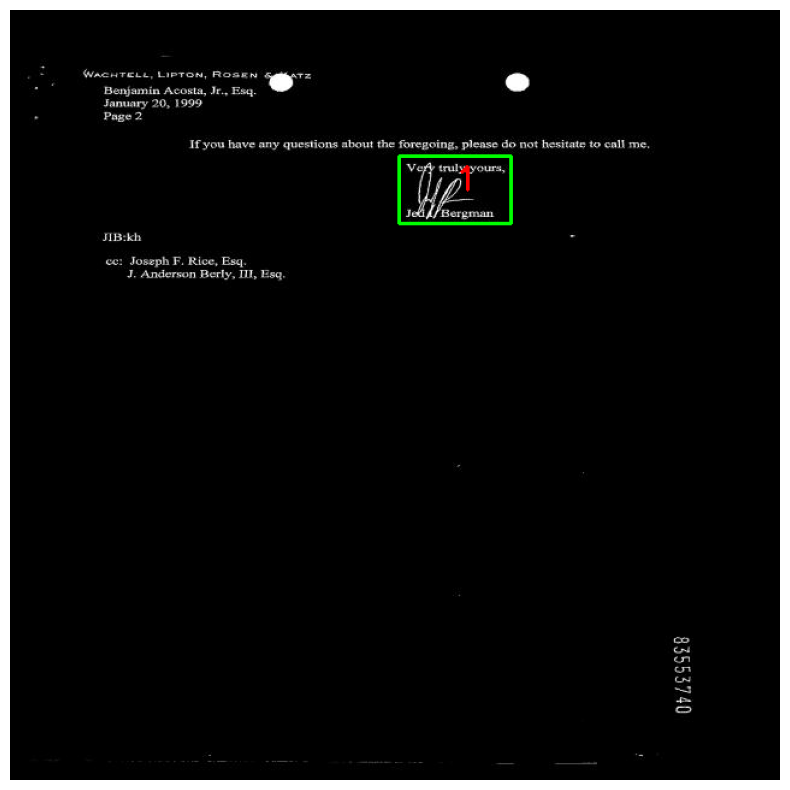

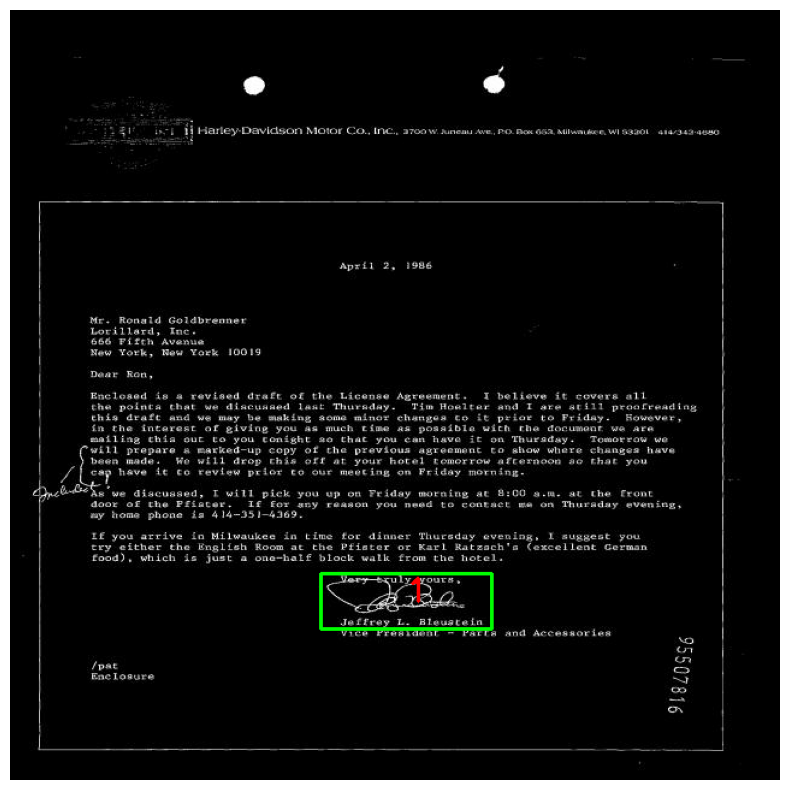

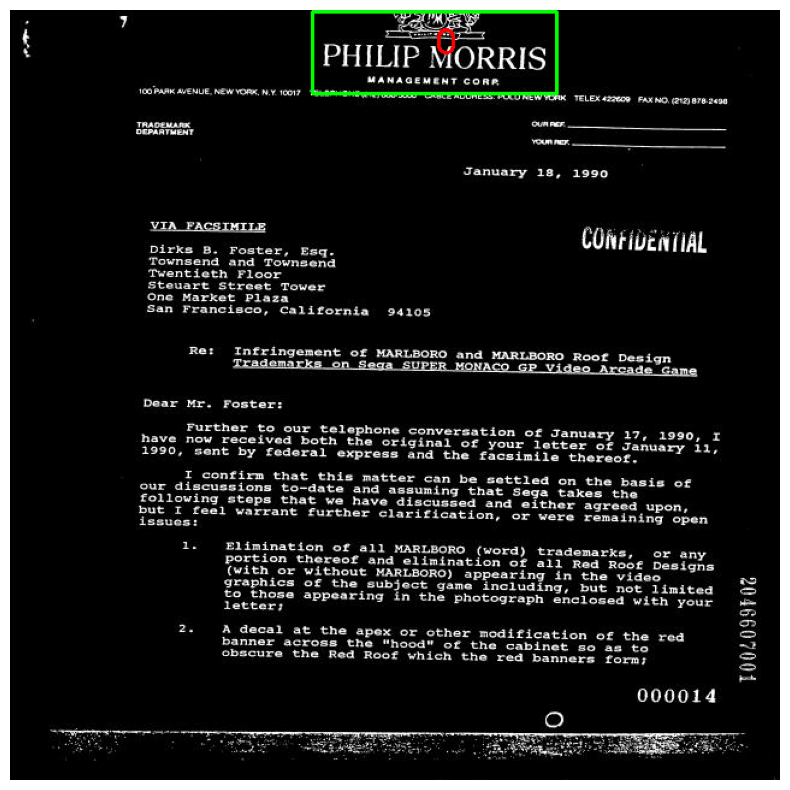

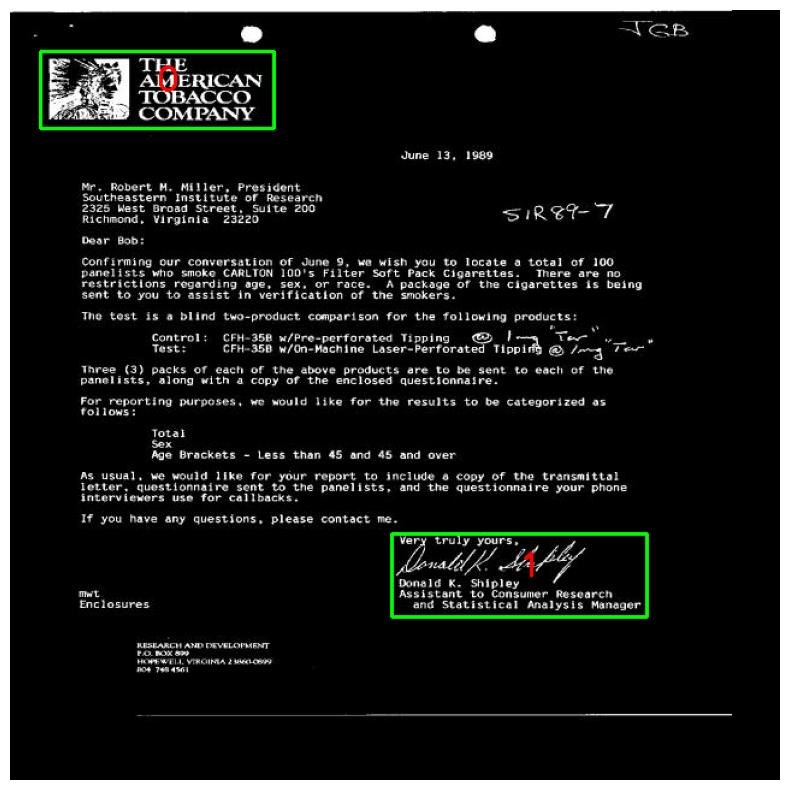

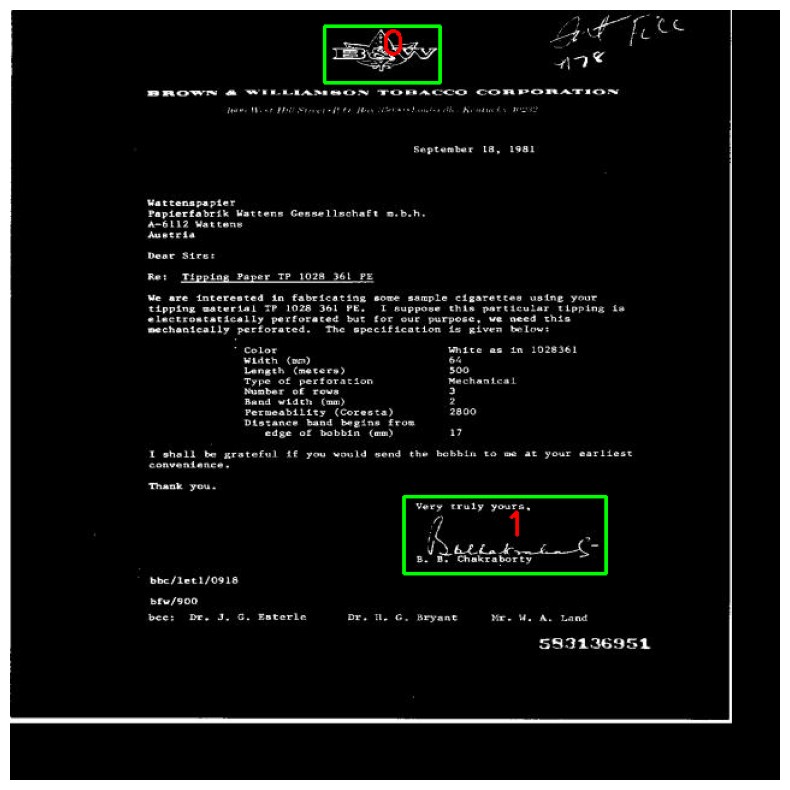

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

def load_yolo_annotations(annotation_file):
    """
    Load YOLOv5 annotations from a file.
    """
    annotations = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            annotations.append((class_id, x_center, y_center, width, height))
    return annotations

def visualize_annotations(image_file, annotation_file):
    """
    Visualize YOLOv5 annotations on an image.
    """
    image = cv2.imread(image_file)
    height, width, _ = image.shape
    annotations = load_yolo_annotations(annotation_file)
    
    for annotation in annotations:
        class_id, x_center, y_center, w, h = annotation
        x_center *= width
        y_center *= height
        w *= width
        h *= height

        x_min = int(x_center - w / 2)
        y_min = int(y_center - h / 2)
        x_max = int(x_center + w / 2)
        y_max = int(y_center + h / 2)
        
        # Draw bounding box
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        # Put class label
        cv2.putText(image, str(int(class_id)), (int(x_center), int(y_center)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # Convert BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Show the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Example usage
dataset_path = '../Yolo_Example/yolov5/IPP-4/'
images_path = os.path.join(dataset_path, 'train', 'images')
annotations_path = os.path.join(dataset_path, 'train', 'labels')

# Visualize a few examples
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
for image_file in image_files[:5]:  # Change the range to visualize more or fewer images
    image_path = os.path.join(images_path, image_file)
    annotation_path = os.path.join(annotations_path, os.path.splitext(image_file)[0] + '.txt')
    if os.path.exists(annotation_path):
        visualize_annotations(image_path, annotation_path)


# Get Ground truth anchor boxes

In [70]:
import os
import numpy as np

def load_yolo_annotations(annotation_file, image_shape):
    """
    Load YOLOv5 annotations from a file.
    """
    h, w, _ = image_shape
    bboxes = []
    with open(annotation_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            _, _, _, width, height = map(float, line.strip().split())
            bboxes.append((width*w, height*h))
    return bboxes

def get_ground_truth_bboxes(dataset_path):
    """
    Extract ground truth bounding box widths and heights from a YOLOv5 formatted dataset.
    
    Parameters:
    - dataset_path: Path to the dataset directory containing the 'train' folder with images and annotations.
    
    Returns:
    - bboxes: List of tuples containing the width and height of each bounding box.
    """
    train_path = os.path.join(dataset_path, 'train')
    annotations_path = os.path.join(train_path, 'labels')
    images_path = os.path.join(dataset_path, 'train', 'images')

    
    bboxes = []
    
    for annotation_file in os.listdir(annotations_path):
        if annotation_file.endswith('.txt'):
            
            
            image_file = os.path.join(images_path, os.path.splitext(annotation_file)[0] + '.jpg')
            image = cv2.imread(image_file)
            
            
            annotation_file_path = os.path.join(annotations_path, annotation_file)
            bboxes += load_yolo_annotations(annotation_file_path, image.shape)
    
    return bboxes


# Example usage
dataset_path = '../Yolo_Example/yolov5/IPP-5/'
bboxes = get_ground_truth_bboxes(dataset_path)

# Print the first 10 bounding boxes
for bbox in bboxes[:10]:
    print(f"Width: {bbox[0]}, Height: {bbox[1]}")



Width: 190.0, Height: 61.5
Width: 148.5, Height: 51.0
Width: 261.5, Height: 120.0
Width: 134.0, Height: 43.5
Width: 136.0, Height: 52.5
Width: 179.5, Height: 67.0
Width: 172.0, Height: 65.5
Width: 130.5, Height: 51.0
Width: 123.0, Height: 45.0
Width: 106.5, Height: 49.5


In [71]:
bboxes = np.asarray(bboxes)



# Define Anchors

In [74]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd

def kmeans_anchors(bboxes, num_anchors):
    kmeans = KMeans(n_clusters=num_anchors, random_state=0).fit(bboxes)
    anchors = kmeans.cluster_centers_
    return anchors

# # Example ground truth bounding boxes (width, height)
# bboxes = np.array([
#     [30, 40],
#     [50, 80],
#     [100, 120],
#     [200, 300],
#     [60, 45],
#     [120, 160],
#     [160, 200],
#     [320, 320],
#     [400, 500],
#     # Add more bounding boxes from your dataset
# ])

# Perform k-means clustering to find the anchor boxes
num_anchors = 9  # Total number of anchors
anchors = kmeans_anchors(bboxes, num_anchors)

factor = num_anchors//3


anchors_df = pd.DataFrame(anchors, columns=["Width", "Height"])
anchors_df["Area"] = anchors_df.iloc[:,0]*anchors_df.iloc[:,1]
anchors_df.sort_values(by="Area", inplace=True)
anchors_df.reset_index(drop=True, inplace=True)


# Scale all anchors according to each feature map size
for i in range(3):
    anchors_p = anchors_df.loc[factor*i : factor*(i+1)-1, ["Width", "Height"]]
    # anchors_p = anchors_df.loc[factor*i : factor*(i+1)-1, :]
    anchor_list = []
    print(f"\nAnchors: {i}", anchors_p.index)
    for j in range(anchors_p.shape[0]):
        W, H = anchors_p.iloc[j, [0,1]]
        anchor_list.append(f"{int(W)},{int(H)}")
    print(str(anchor_list))
    
anchors_df



Anchors: 0 RangeIndex(start=0, stop=3, step=1)
['50,33', '96,50', '131,45']

Anchors: 1 RangeIndex(start=3, stop=6, step=1)
['174,52', '147,66', '219,47']

Anchors: 2 RangeIndex(start=6, stop=9, step=1)
['194,71', '263,57', '233,84']


,Width,Height,Area
0,50.220588,33.911765,1703.068772
1,96.107143,50.878571,4889.794133
2,131.500000,45.401786,5970.334821
3,174.072222,52.672222,9168.770772
4,147.486842,66.171053,9759.359591
5,219.171429,47.214286,10348.022449
6,194.959459,71.405405,13921.159240
7,263.714286,57.178571,15078.806122
8,233.982143,84.946429,19875.947385
